In [13]:
import pandas as pd

# ==== DATA CLEANING ====

# Load exchange rates and transactions from CSV files
# Strip extra spaces from column names
# Convert the "Effective date" column to datetime
# Clean up currency codes by removing brackets and trimming whitespace
# Extract proper ISO currency codes from text columns
# Sort exchange rates and transaction data chronologically

rates = pd.read_csv("exchange rates.csv")
transactions_df = pd.read_csv("dane_zmienione.csv", parse_dates=["SERVICE_DATE", "TRANSACTION_DATE", "ORDER_DATE"],
                              dayfirst=True)

rates.columns = rates.columns.str.strip()
rates["Effective date"] = pd.to_datetime(rates["Effective date"].str.strip(), dayfirst=True)

rates["Currency from"] = rates["Currency from"].str.replace(r"[\[\]]", "", regex=True).str.strip()
rates["Currency to"] = rates["Currency to"].str.replace(r"[\[\]]", "", regex=True).str.strip()

From = []
To = []
for i in list(rates['Currency from']):
    From.append(i.split()[0])

for i in list(rates['Currency to']):
    To.append(i.split()[0])

rates["Currency from"] = From
rates["Currency to"] = To

rates = rates.sort_values("Effective date")
transactions_df = transactions_df.sort_values("SERVICE_DATE")

transactions_df.sample(10)

C:\Users\u197719\AppData\Local\Temp\ipykernel_11408\2931127228.py:5: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  transactions_df = pd.read_csv("dane_zmienione.csv", parse_dates=["SERVICE_DATE", "TRANSACTION_DATE", "ORDER_DATE"],
C:\Users\u197719\AppData\Local\Temp\ipykernel_11408\2931127228.py:5: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  transactions_df = pd.read_csv("dane_zmienione.csv", parse_dates=["SERVICE_DATE", "TRANSACTION_DATE", "ORDER_DATE"],


,CUS_ID,TRN_ID,VENDOR_ID,M_ENTITY,O_ENTITY,PROCESSING_DATE,SERVICE_DATE,TRANSACTION_DATE,ORDER_DATE,TRANSACTION_CODE,FEE_CURRENCY,BASE_CURRENCY,TARGET_CURRENCY,EXCHANGE_RATE,BASE_REVENUE,BASE_REVENUE_LOCAL,CALCULATION_FACTOR,CALCULATED_VALUE
7030,7031,2970,B,B,3B,2025-08-19,2025-07-05,2025-04-19,2025-04-29,X,NaN,USD,GBP,0.79289,800.00,634.31,2,1268.62
6784,6785,3216,B,B,3B,2025-05-10,2025-01-23,2025-03-18,2025-05-04,Y,EUR,EUR,GBP,0.82760,59.52,49.26,2,98.52
8031,8032,1969,B,B,3B,2025-07-16,2025-02-13,2025-08-20,2025-04-14,X,NaN,EUR,GBP,0.82760,98.33,81.38,2,162.76
7806,7807,2194,B,B,3B,2025-02-24,2025-02-22,2025-08-03,2025-07-30,Y,USD,USD,GBP,0.79289,133.00,105.45,2,210.90
3771,3772,6229,B,B,3B,2025-02-23,2025-01-22,2025-03-31,2025-01-23,X,NaN,EUR,GBP,0.82760,22.32,18.47,2,36.94
4557,4558,5443,B,B,3B,2025-03-08,2025-09-05,2025-01-02,2025-07-23,X,NaN,PLN,GBP,0.19407,204.00,39.59,2,79.18
6035,6036,3965,B,B,3B,2025-02-18,2025-09-12,2025-08-31,2025-04-29,X,NaN,EUR,GBP,0.82760,188.89,156.33,3,468.99
8852,8853,1148,B,B,3B,2025-03-04,2025-02-05,2025-04-08,2025-07-25,X,NaN,USD,GBP,0.79289,343.49,272.35,2,544.70
1662,1663,8338,I,I,KA,2025-02-14,2025-01-07,2025-09-16,2025-07-25,X,NaN,CHF,EUR,1.06988,54.00,57.77,1,57.77
6513,6514,3487,A,A,ZZ,2025-07-27,2025-02-23,2025-02-20,2025-06-14,X,NaN,USD,GBP,0.79289,718.00,569.30,5,2846.50


In [14]:
# ==== PIVOT TABLE FOR EXCHANGE RATES ====

# Index: Effective date
# Columns: (Currency from, Currency to)
# Values: exchange rate
# This allows quick lookup of historical rates for any currency pair

rates_wide = rates.pivot_table(index="Effective date", columns=["Currency from", "Currency to"], values="Rate")

rates_wide["USD", "GBP"]

Effective date
2025-01-01    0.81486
2025-02-01    0.79237
2025-03-01    0.77177
2025-04-01    0.75041
2025-05-01    0.74809
2025-06-01    0.74225
2025-07-01    0.74127
2025-08-01    0.74110
Name: (USD, GBP), dtype: float64

In [15]:
# ==== CHECK EXCHANGE RATE FOR SPECIFIC TRANSACTION DATE ====

# Define helper functions:
# - get_currency: decide whether to use FEE_CURRENCY or BASE_CURRENCY
# - get_date: decide whether to use TRANSACTION_DATE or ORDER_DATE
# - get_rate: select the latest valid exchange rate before the transaction date
# Apply the logic to each transaction and create a new column EXCHANGE_RATE_CORRECTED

def get_currency(row):
    if pd.isna(row["FEE_CURRENCY"]):
        return row["BASE_CURRENCY"]
    else:
        return row["FEE_CURRENCY"]

def get_date(row):
    if pd.notna(row["TRANSACTION_DATE"]):
        return row["TRANSACTION_DATE"]
    else:
        return row["ORDER_DATE"]

def get_rate(row):
    valid_rates = rates_wide[rates_wide.index <= get_date(row)]
    last_rate = valid_rates.iloc[-1]
    ex_rate_in_date = last_rate[(get_currency(row), row["TARGET_CURRENCY"])]
    return ex_rate_in_date

transactions_df["EXCHANGE_RATE_CORRECTED"] = transactions_df.apply(get_rate, axis=1)

In [19]:
# ==== CALCULATE CORRECTED LOCAL VALUE AND TOTAL VALUE DIFFERENCE ====

# Recalculate base revenue in local currency using the corrected exchange rate
# Apply calculation factor to get the corrected final value
# Calculate the difference: original vs corrected value
# Sum up all differences to check total over- or under-awarded value

transactions_df["BASE_REVENUE_LOCAL_CORRECTED"] = transactions_df["BASE_REVENUE"] * transactions_df["EXCHANGE_RATE_CORRECTED"]

transactions_df["CALCULATED_VALUE_CORRECTED"] = transactions_df["BASE_REVENUE_LOCAL_CORRECTED"] * transactions_df[
    "CALCULATION_FACTOR"]

transactions_df["CALCULATED_VALUE_CORRECTED"] = round(transactions_df["CALCULATED_VALUE_CORRECTED"], 0)

transactions_df["VALUE_DIFFERENCE"] = transactions_df["CALCULATED_VALUE"] - transactions_df[
    "CALCULATED_VALUE_CORRECTED"]

value_difference = transactions_df["VALUE_DIFFERENCE"].sum()
value_difference = int(value_difference)

if value_difference > 0:
    total_balance_after_correction = f"Overawarded value: {value_difference:,}"
else:
    total_balance_after_correction = f"Unawarded value: {value_difference:,}"

print(total_balance_after_correction)

Overawarded value: 285,755


In [20]:
# Create a TRANSACTION_CURRENCY column
# If FEE_CURRENCY is available -> use it
# Otherwise -> fallback to BASE_CURRENCY

transactions_df["TRANSACTION_CURRENCY"] = transactions_df.apply(
    lambda row: row["FEE_CURRENCY"] if pd.notna(row["FEE_CURRENCY"]) else row["BASE_CURRENCY"],
    axis=1
)

transactions_df.iloc[600]

CUS_ID                                         2513
TRN_ID                                         7488
VENDOR_ID                                         B
M_ENTITY                                          B
O_ENTITY                                         3B
PROCESSING_DATE                          2025-08-28
SERVICE_DATE                             2025-01-17
TRANSACTION_DATE                2025-01-23 00:00:00
ORDER_DATE                      2025-03-19 00:00:00
TRANSACTION_CODE                                  X
FEE_CURRENCY                                    NaN
BASE_CURRENCY                                   AED
TARGET_CURRENCY                                 GBP
EXCHANGE_RATE                               0.21584
BASE_REVENUE                                1157.69
BASE_REVENUE_LOCAL                           249.88
CALCULATION_FACTOR                                2
CALCULATED_VALUE                             499.76
EXCHANGE_RATE_CORRECTED                     0.22182
BASE_REVENUE

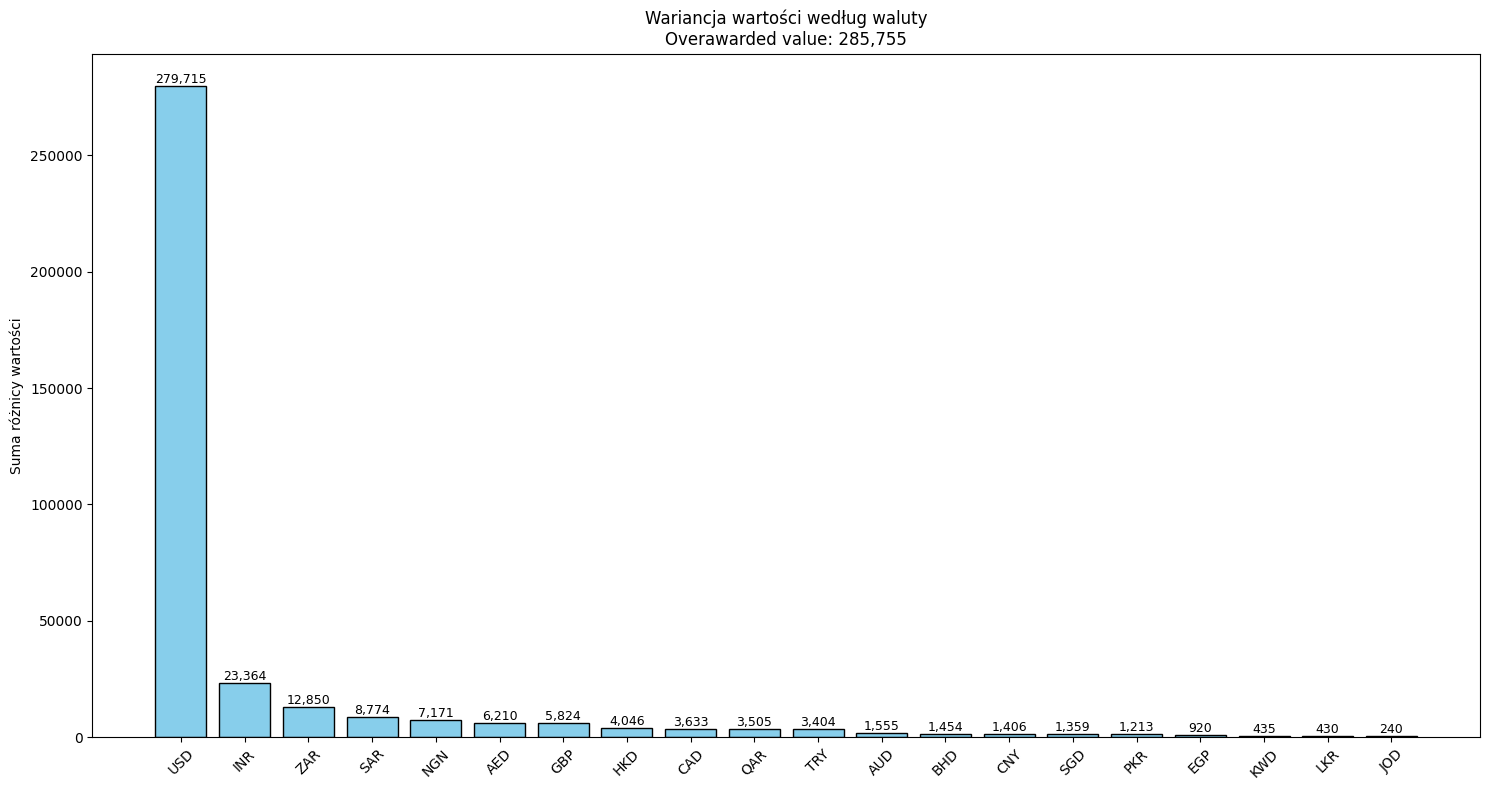

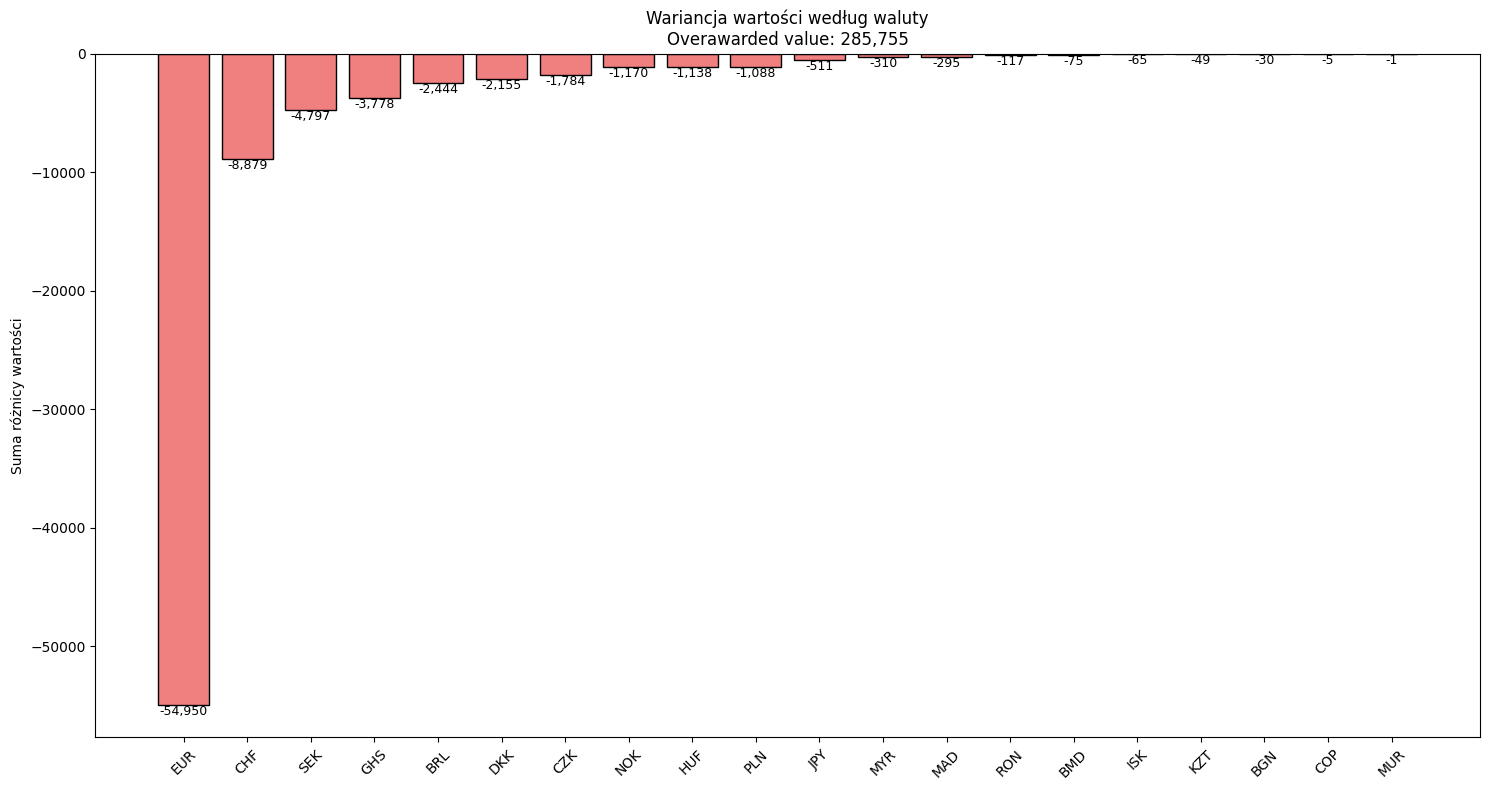

In [21]:
# ==== CHART - VALUE DIFFERENCE PER CURRENCY ====

# Group VALUE_DIFFERENCE by TRANSACTION_CURRENCY
# Show top 20 currencies with the largest positive differences (overawarded)
# Plot bar chart with labels above bars

import matplotlib.pyplot as plt

top20_currency = transactions_df.groupby("TRANSACTION_CURRENCY")["VALUE_DIFFERENCE"].sum().nlargest(20)

plt.figure(figsize=(15, 8))
bars = plt.bar(top20_currency.index, top20_currency.values, color="skyblue", ec="black")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:,.0f}",
             ha="center", va="bottom", fontsize=9)

plt.title(f"Wariancja wartości według waluty\n{total_balance_after_correction}")
plt.ylabel("Suma różnicy wartości")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Repeat for bottom 20 (most negative → underawarded)

bottom20_currency = transactions_df.groupby("TRANSACTION_CURRENCY")["VALUE_DIFFERENCE"].sum().nsmallest(20)

plt.figure(figsize=(15, 8))
bars = plt.bar(bottom20_currency.index, bottom20_currency.values, color="lightcoral", ec="black")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:,.0f}",
             ha="center", va="top", fontsize=9)

plt.title(f"Wariancja wartości według waluty\n{total_balance_after_correction}")
plt.ylabel("Suma różnicy wartości")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

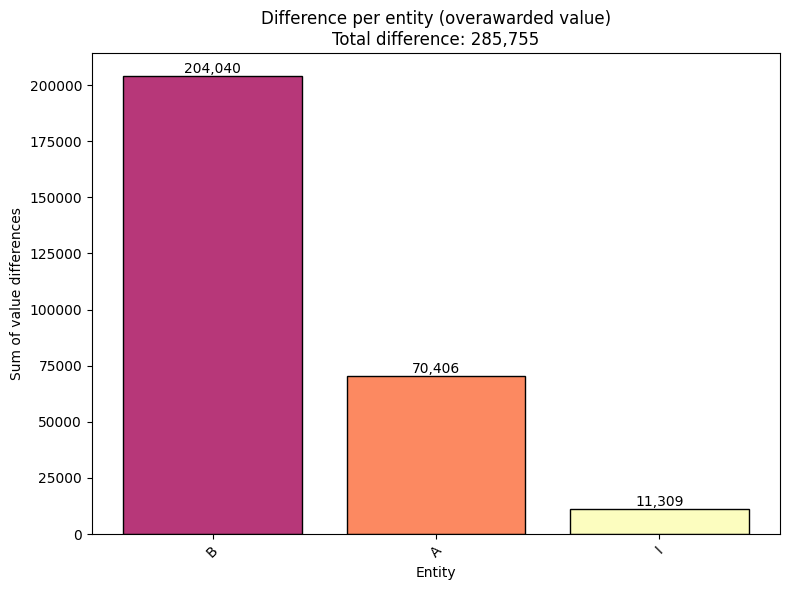

In [58]:
# ==== CHART - VALUE DIFFERENCE PER ENTITY ====
import numpy as np

m_group = transactions_df.groupby("M_ENTITY")["VALUE_DIFFERENCE"].sum().sort_values(ascending=False)

plt.figure(figsize=(8,6))

cmap = plt.get_cmap("magma")
colors = cmap(np.linspace(0.5, 1, len(m_group)))

bars = plt.bar(m_group.index, m_group.values, color=colors, ec="black")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:,.0f}",
             ha="center", va="bottom", fontsize=10)

plt.title(f"Difference per entity (overawarded value)\nTotal difference: {value_difference:,}")
plt.ylabel("Sum of value differences")
plt.xlabel("Entity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
# ==== CHART - MONTHLY DFFERENCES ====

# Convert SERVICE_DATE to datetime
# Create YEAR_MONTH column (monthly periods)

transactions_df["SERVICE_DATE"] = pd.to_datetime(transactions_df["SERVICE_DATE"], errors="coerce")
transactions_df["YEAR_MONTH"] = transactions_df["SERVICE_DATE"].dt.to_period("M")

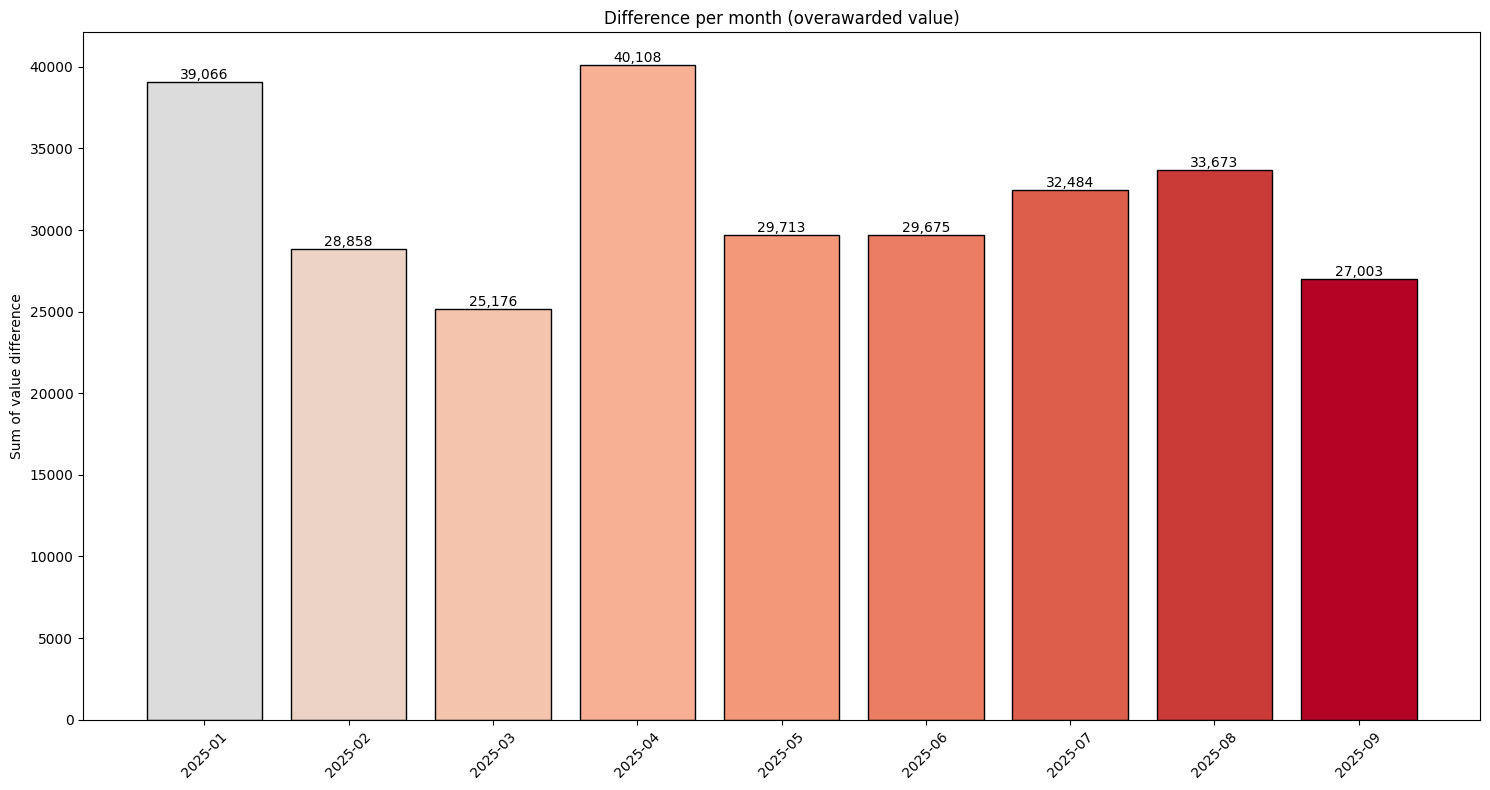

In [59]:
# Group VALUE_DIFFERENCE by YEAR_MONTH
# Annotate each bar with its value

transactions_df["YEAR_MONTH"] = transactions_df["SERVICE_DATE"].dt.to_period("M")

monthly_group = transactions_df.groupby("YEAR_MONTH")["VALUE_DIFFERENCE"].sum()

cmap = plt.get_cmap("coolwarm")
colors = cmap(np.linspace(0.5, 1, len(monthly_group)))

plt.figure(figsize=(15,8))
bars = plt.bar(monthly_group.index.astype(str), monthly_group.values, color=colors, ec="black")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:,.0f}",
             ha="center", va="bottom", fontsize=10)

plt.title("Difference per month (overawarded value)")
plt.ylabel("Sum of value difference")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
# ==== CHART - CURRENCY PAIR ANALYSIS ====

# Group VALUE_DIFFERENCE by (TRANSACTION_CURRENCY, TARGET_CURRENCY)
# Sort descending to find most overawarded pairs

currency_diff = transactions_df.groupby(["TRANSACTION_CURRENCY", "TARGET_CURRENCY"])["VALUE_DIFFERENCE"].sum().reset_index().sort_values(ascending=False, by="VALUE_DIFFERENCE")

currency_diff.columns = ["Currency from", "Currency to", "Overawarded value"]

print(currency_diff.to_string(index=False))

Currency from Currency to  Overawarded value
          USD         GBP          274488.42
          INR         GBP           23363.98
          ZAR         GBP           12850.45
          SAR         GBP            8774.29
          NGN         GBP            7170.73
          AED         GBP            6209.52
          GBP         EUR            5824.08
          USD         EUR            5226.57
          HKD         GBP            3990.58
          CAD         GBP            3510.74
          QAR         GBP            3504.54
          TRY         GBP            3402.41
          AUD         GBP            1555.10
          BHD         GBP            1453.98
          CNY         GBP            1406.68
          SGD         GBP            1359.37
          PKR         GBP            1213.48
          EGP         GBP             919.58
          KWD         GBP             435.30
          LKR         GBP             429.68
          JOD         GBP             239.74
          

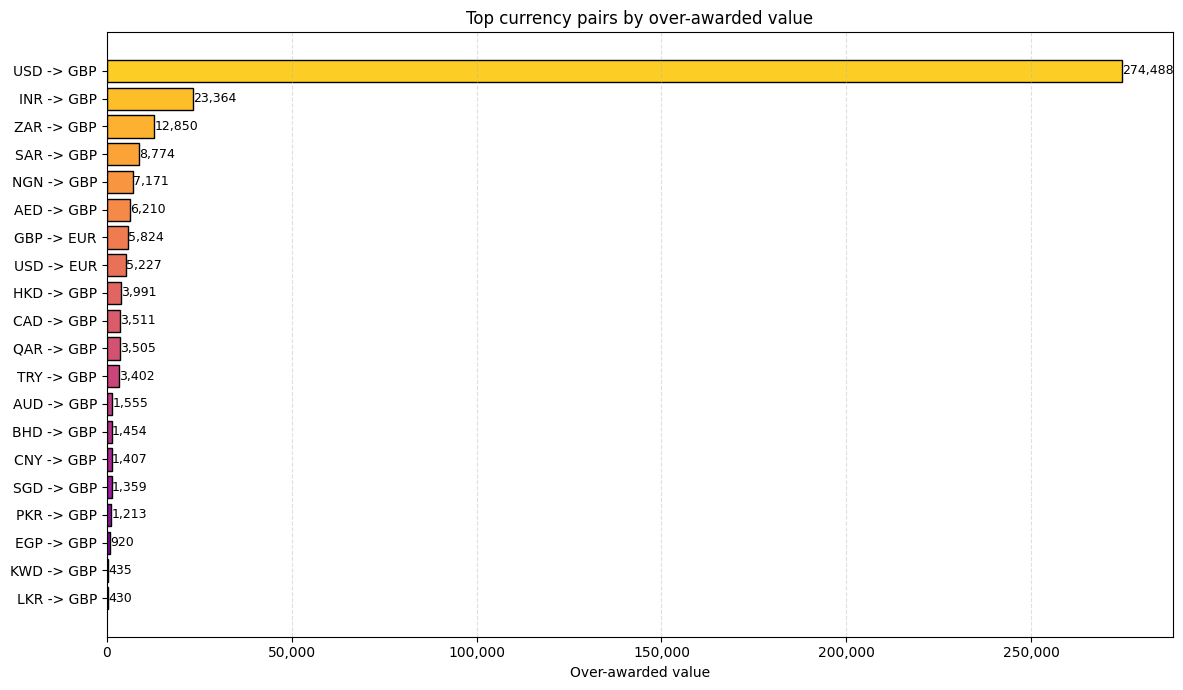

In [37]:
# ==== CHART - TOP CURRENCY PAIRS ====

import matplotlib.ticker as mtick

top_pairs = currency_diff.sort_values("Overawarded value", ascending=False).head(20)
top_pairs = top_pairs.iloc[::-1]

labels = top_pairs["Currency from"] + " -> " + top_pairs["Currency to"]
heights = top_pairs["Overawarded value"].values

cmap = plt.get_cmap("plasma")
colors = cmap(np.linspace(0.2, 0.9, len(heights)))

fig, ax = plt.subplots(figsize=(12,7))
bars = ax.barh(labels, heights, color=colors, edgecolor="black")

for bar in bars:
    w = bar.get_width()
    ax.text(w, bar.get_y() + bar.get_height()/2, f"{w:,.0f}",
            ha="left", va="center", fontsize=9)

ax.set_xlabel("Over-awarded value")
ax.set_title("Top currency pairs by over-awarded value")

ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

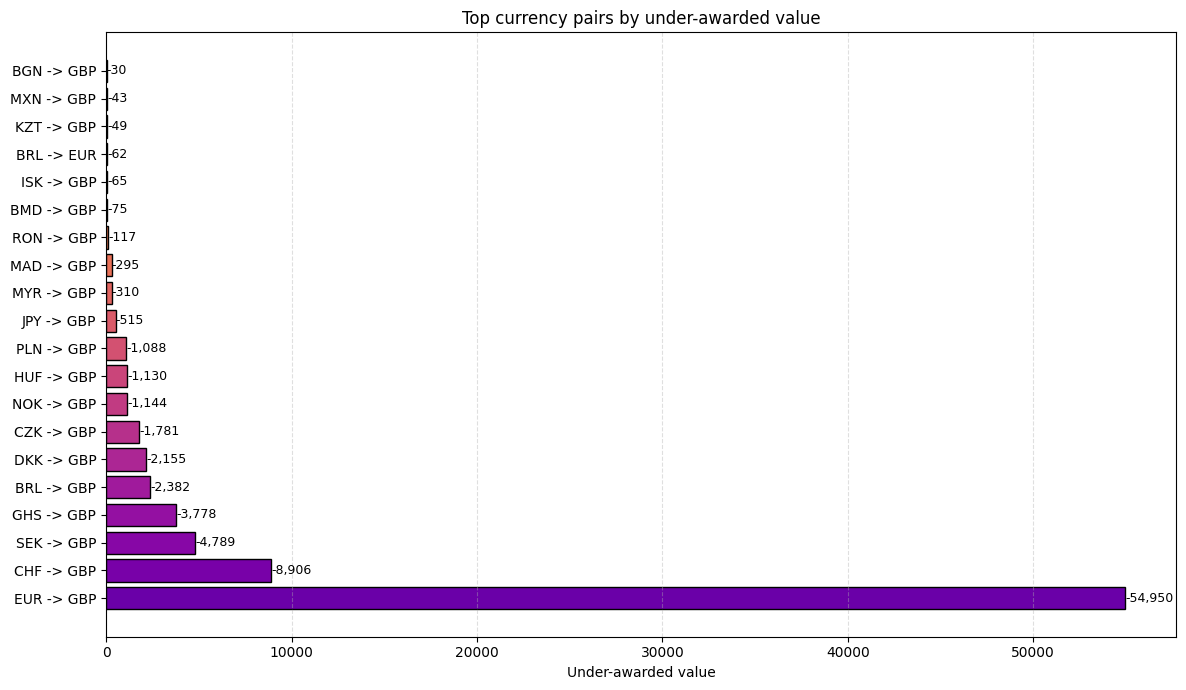

In [40]:
# ==== CHART - BOTTOM CURRENCY PAIRS ====

top_pairs = currency_diff.sort_values("Overawarded value", ascending=True).head(20)

labels = top_pairs["Currency from"] + " -> " + top_pairs["Currency to"]
heights = top_pairs["Overawarded value"].values

cmap = plt.get_cmap("plasma")
colors = cmap(np.linspace(0.2, 0.9, len(heights)))

fig, ax = plt.subplots(figsize=(12,7))
bars = ax.barh(labels, -heights, color=colors, edgecolor="black")

for bar in bars:
    w = bar.get_width()
    ax.text(w, bar.get_y() + bar.get_height()/2, f"{-w:,.0f}",
            ha="left", va="center", fontsize=9)

ax.set_xlabel("Under-awarded value")
ax.set_title("Top currency pairs by under-awarded value")

ax.grid(axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

Average percentage variance: 3.93


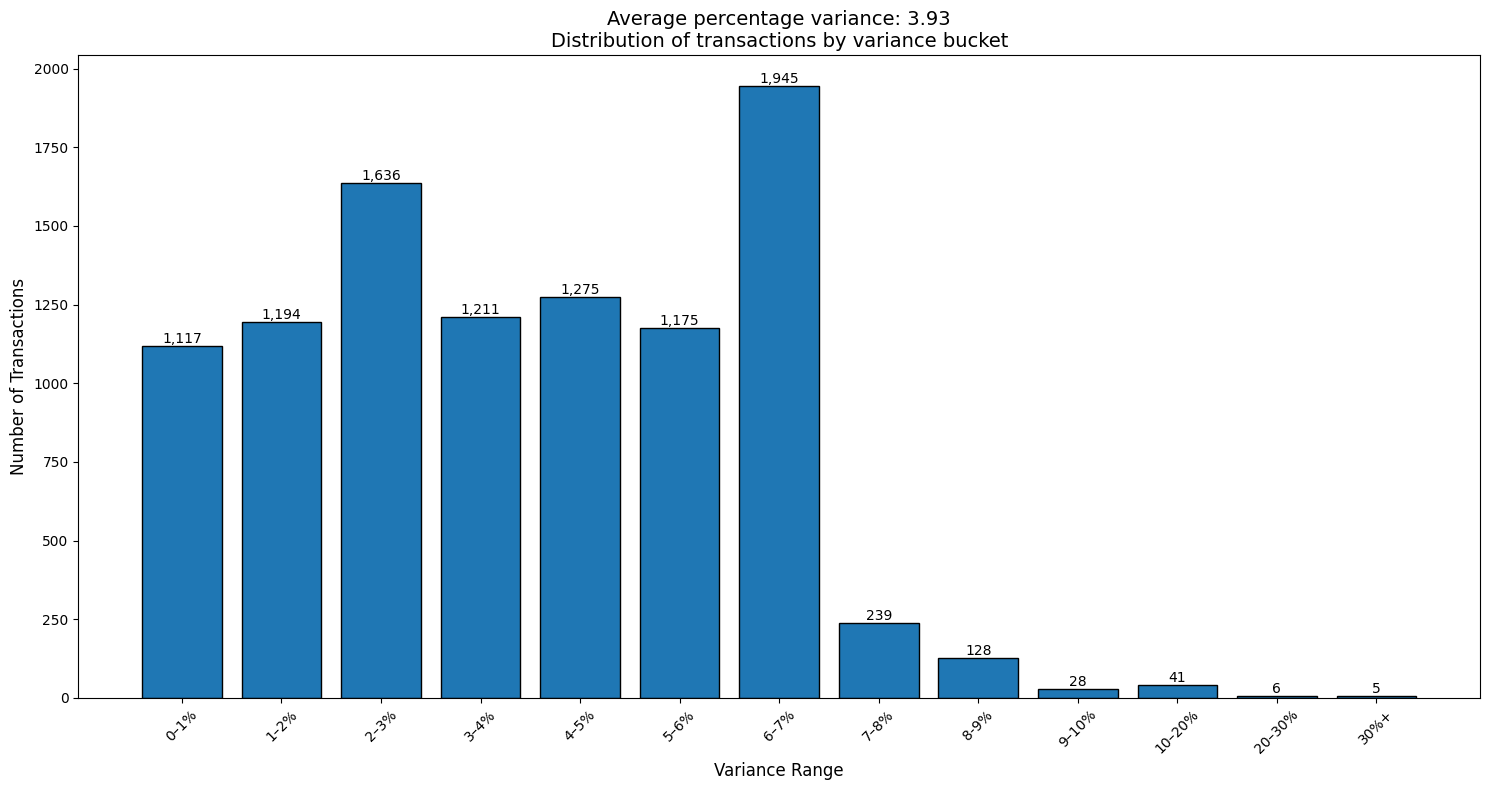

In [53]:
# ======= OUTLIERS =======

# Calculate percentage difference (VALUE_DIFFERENCE / CALCULATED_VALUE)
# Compute average absolute variance
# Bucket transactions into variance ranges (0–1%, 1–2%, …, 30%+)
# Count transactions per bucket
# Plot distribution as a bar chart with labels

transactions_df["PCT_DIFF"] = transactions_df["VALUE_DIFFERENCE"] / transactions_df["CALCULATED_VALUE"] * 100

avg_variance = transactions_df["PCT_DIFF"].abs().mean()

bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, float("inf")]
labels = ["0–1%", "1–2%", "2–3%", "3–4%", "4–5%", "5–6%", "6–7%", "7–8%", "8-9%", "9–10%", "10–20%", "20–30%", "30%+"]
transactions_df["BUCKET"] = pd.cut(transactions_df["PCT_DIFF"].abs(),
                      bins=bins,
                      labels=labels,
                      right=False)

bucket_counts = transactions_df["BUCKET"].value_counts().sort_index()

print(f"Average percentage variance: {avg_variance:.2f}")

plt.figure(figsize=(15,8))
bars = plt.bar(bucket_counts.index.astype(str), bucket_counts.values, ec="black")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:,.0f}",
             ha="center", va="bottom", fontsize=10)

plt.title(f"Average percentage variance: {avg_variance:.2f}\nDistribution of transactions by variance bucket", fontsize=14)
plt.xlabel("Variance Range", fontsize=12)
plt.ylabel("Number of Transactions", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()